### Extract section across Atlantic

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw

import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## functions

In [3]:
### function to fix non-monotonic longitude
def fix_orca_longitude(input_lon):
    j_step, i_step = np.where(np.diff(input_lon, axis=1) < 0)
    
    output_lon = input_lon.copy()
    
    for j,i in zip(j_step,i_step):
        output_lon[j, i+1:] = (input_lon[j, i+1:].values + 360)
        
    return output_lon - 360

## load data

In [4]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
land_maskO = mask.tmask.isel(X=range(750,1250)).rename({'X':'x','Y':'y','z':'deptht'})

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsMO = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

## only atlantic and mask land values based on native ORCA025 grid
maskO = (land_maskO*dsMO.tmask)
maskO[:,852:,:] = 0 ## remove atlantic points outside nest domain
maskO[:,0:353,:] = 0 

A = (dsMO.e1t * dsMO.e2t).where(maskO == 1).compute()

In [5]:
def load_stats(EXP, baseline, var):
    path = f'/gxfs_work/geomar/smomw379/DATA/{EXP}/MHW_Detection/ANALYSIS/'
    ds_00 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-00.nc')
    ds_10 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-10.nc')
    ds_23 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-23.nc')
    ds_30 = xr.open_dataset(path+f'{EXP}_1y_19800101_20221231_{var}-{baseline}-30.nc')

    return ds_00, ds_10, ds_23, ds_30

In [6]:
## ORCA025-6th
dsO6_R_00_WMO, dsO6_R_10_WMO, dsO6_R_23_WMO, dsO6_R_30_WMO = load_stats('ORCA025.L46-KFS003-V-6th', 'WMO', 'Duration')
dsO6_E_00_WMO, dsO6_E_10_WMO, dsO6_E_23_WMO, dsO6_E_30_WMO = load_stats('ORCA025.L46-KFS003-V-6th', 'WMO', 'Events')
dsO6_M_00_WMO, dsO6_M_10_WMO, dsO6_M_23_WMO, dsO6_M_30_WMO = load_stats('ORCA025.L46-KFS003-V-6th', 'WMO', 'IntensityMax')


In [7]:
## VIKING20X-6th
dsB6_R_00_WMO, dsB6_R_10_WMO, dsB6_R_23_WMO, dsB6_R_30_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'Duration')
dsB6_E_00_WMO, dsB6_E_10_WMO, dsB6_E_23_WMO, dsB6_E_30_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'Events')
dsB6_M_00_WMO, dsB6_M_10_WMO, dsB6_M_23_WMO, dsB6_M_30_WMO = load_stats('VIKING20X.L46-KFS003-6th', 'WMO', 'IntensityMax')

## maps

In [8]:
### difference 
DUR_23_map = np.ma.masked_equal(dsB6_R_23_WMO.Duration_mn.mean('time') *  maskO.isel(deptht=23),0)

EVT_23_map = np.ma.masked_equal(dsB6_E_23_WMO.N_events.mean('time')  *  maskO.isel(deptht=23),0)

INT_23_map = np.ma.masked_equal(dsB6_M_23_WMO.Intensity_max_mn.where(dsB6_M_00_WMO.Intensity_max_mn>0).mean('time') *  maskO.isel(deptht=23),0)


In [9]:
### difference 
dDUR_23_map = np.ma.masked_equal((dsB6_R_23_WMO.Duration_mn.mean('time') -
                                 dsO6_R_23_WMO.Duration_mn.mean('time')) *  maskO.isel(deptht=23),0)

dEVT_23_map = np.ma.masked_equal((dsB6_E_23_WMO.N_events.mean('time') -
                                 dsO6_E_23_WMO.N_events.mean('time')) *  maskO.isel(deptht=23),0)

dINT_23_map = np.ma.masked_equal((dsB6_M_23_WMO.Intensity_max_mn.where(dsB6_M_00_WMO.Intensity_max_mn>0).mean('time') -
                                 dsO6_M_23_WMO.Intensity_max_mn.where(dsO6_M_00_WMO.Intensity_max_mn>0).mean('time')) *  maskO.isel(deptht=23),0)


## Area averages

In [10]:
def area_average(dsL, dsI, dsE, A):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## ignore grid points where no heatwaves occured for event based averages (duration, intensity)
    ## don't ignore them for grid point based averages (MHW days per year and Events per year)
    Area_averageL =  (dsL.where(dsL!=0).Duration_mn * A).sum(('x','y')) / A.where(dsL.Duration_mn!=0).sum(('x','y'))
    Area_averageI =  (dsI.where(dsI!=0).Intensity_max_mn * A).sum(('x','y')) / A.where(dsI.Intensity_max_mn>0).sum(('x','y'))
    Area_averageE =  (dsE.N_events * A).sum(('x','y')) / A.sum(('x','y'))

    return  Area_averageL, Area_averageI, Area_averageE

In [13]:
## 1000 m
DUR_domain_B6_23_WMO, INT_domain_B6_23_WMO, EVT_domain_B6_23_WMO = area_average(dsB6_R_23_WMO, dsB6_M_23_WMO, dsB6_E_23_WMO, A.isel(deptht=23))
DUR_domain_O6_23_WMO, INT_domain_O6_23_WMO, EVT_domain_O6_23_WMO = area_average(dsO6_R_23_WMO, dsO6_M_23_WMO, dsO6_E_23_WMO, A.isel(deptht=23))

## plotting

In [15]:
coastline = cft.GSHHSFeature(scale='intermediate')

def plot_cartopy(ax, xticks, yticks, ylabels=True, xlabels=True, continents=True):
    '''Add cartopy features to the map'''
    if continents:
       ax.add_feature(coastline, edgecolor='darkgrey', facecolor='darkgrey', zorder=100)

    ## add labels
    ax.set_xticks(xticks, crs = ccrs.PlateCarree())
    ax.set_yticks(yticks, crs = ccrs.PlateCarree())
    if xlabels:
      lon_formatter = LongitudeFormatter()
      ax.xaxis.set_major_formatter(lon_formatter)
    else: 
       ax.set_xticklabels([])
    if ylabels:
      lat_formatter = LatitudeFormatter()
      ax.yaxis.set_major_formatter(lat_formatter)
    else: 
       ax.set_yticklabels([])

In [16]:
lonO=dsMO.nav_lon
latO=dsMO.nav_lat

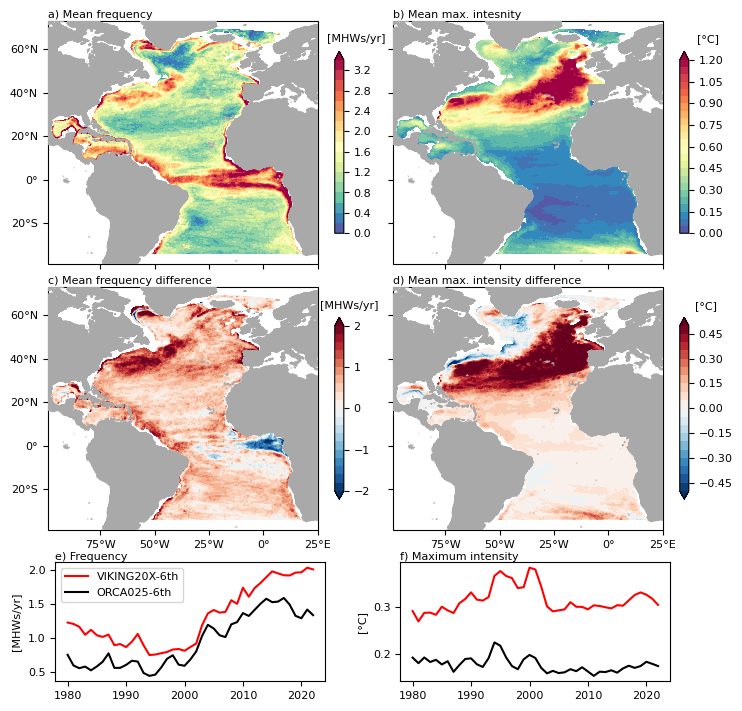

In [19]:
fig = plt.figure(figsize=(7.5,7.))

ax1 = fig.add_axes([0.05,0.6,0.45,0.4], projection=ccrs.PlateCarree())
ax2 = fig.add_axes([0.05,0.22,0.45,0.4], projection=ccrs.PlateCarree())
ax4 = fig.add_axes([0.06,0.03,0.36,0.17])

ax5 = fig.add_axes([0.51,0.6,0.45,0.4], projection=ccrs.PlateCarree())
ax6 = fig.add_axes([0.51,0.22,0.45,0.4], projection=ccrs.PlateCarree())
ax8 = fig.add_axes([0.52,0.03,0.36,0.17])


#####  Mean
##
ctf = ax1.contourf(lonO, latO, EVT_23_map, cmap='Spectral_r', levels=np.arange(0,3.6,0.2), extend='max')
ax1.set_extent([-99,20,-22,59])
plot_cartopy(ax1, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False)
ax1.set_title('a) Mean frequency', loc='left', fontsize=8, pad=2)
cb = plt.colorbar(ctf, ax=[ax1],orientation='vertical', shrink=0.65, pad=0.05)
cb.set_label('[MHWs/yr]', y=1.15, labelpad=-11, fontsize=8, rotation=0)

##
ctf = ax5.contourf(lonO, latO, INT_23_map, cmap='Spectral_r', levels=np.arange(0,1.25,0.05), extend='max')
ax5.set_extent([-99,20,-22,59])
plot_cartopy(ax5, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False, ylabels=False)
ax5.set_title('b) Mean max. intesnity', loc='left', fontsize=8, pad=2)
cb = plt.colorbar(ctf, ax=[ax5],orientation='vertical', shrink=0.65, pad=0.05)
cb.set_label('[°C]', y=1.15, labelpad=-11, fontsize=8, rotation=0)

######  Difference
##
ctf = ax2.contourf(lonO, latO, dEVT_23_map, cmap='RdBu_r', levels=np.arange(-2,2.2,0.2), extend='both')
ax2.set_extent([-99,20,-22,59])
plot_cartopy(ax2, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20))
ax2.set_title('c) Mean frequency difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax2],orientation='vertical', shrink=0.65, pad=0.05)
cb.set_label('[MHWs/yr]', y=1.15, labelpad=-15, fontsize=8, rotation=0)
cb.set_ticks(np.arange(-2,2.1,1))

##
ctf = ax6.contourf(lonO, latO, dINT_23_map, cmap='RdBu_r', levels=np.arange(-0.5,0.55,0.05), extend='both')
ax6.set_extent([-99,20,-22,59])
plot_cartopy(ax6, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False)
ax6.set_title('d) Mean max. intensity difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax6],orientation='vertical', shrink=0.65, pad=0.05)
cb.set_label('[°C]', y=1.15, labelpad=-19, fontsize=8, rotation=0)

######   timeseries
##
ax4.plot(np.arange(1980,2023), EVT_domain_B6_23_WMO, 'r', label='VIKING20X-6th')
ax4.plot(np.arange(1980,2023), EVT_domain_O6_23_WMO, 'k', label='ORCA025-6th')
ax4.set_title('e) Frequency', loc='left', fontsize=8, pad=2)
ax4.set_ylabel('[MHWs/yr]', fontsize=8)
ax4.legend(fontsize=8)

##
ax8.plot(np.arange(1980,2023), INT_domain_B6_23_WMO, 'r') 
ax8.plot(np.arange(1980,2023), INT_domain_O6_23_WMO, 'k')
ax8.set_title('f) Maximum intensity', loc='left', fontsize=8, pad=2)
ax8.set_ylabel('[°C]', fontsize=8)

plt.savefig('Resolution_maps.png')

### supplements

In [17]:
## gradients from mean temperature
path = '/gxfs_work/geomar/smomw379/DATA/ORCA025.L46-KFS003-V-6th/'
dsT_O6 = xr.open_dataset(path+'ORCA025.L46-KFS003-V-6th_43y_19800101_20211231_T_mean.nc')

In [18]:
#### 1000 m
## derivatives
dT_dx_O6 = dsT_O6.where(dsMO.tmask!=0).isel(deptht=23).votemper_mn.differentiate('x') / dsMO.e1t
dT_dy_O6 = dsT_O6.where(dsMO.tmask!=0).isel(deptht=23).votemper_mn.differentiate('y') / dsMO.e2t
dT_dz_O6 = dsT_O6.where(dsMO.tmask!=0).votemper_mn.differentiate('deptht') / dsMO.e3t_0

## absolute value of the gradient
gradT_23_O6 = (dT_dx_O6**2 + dT_dy_O6**2)**(0.5)
gradT_z23_O6 = np.abs(dT_dz_O6.isel(deptht=23))

In [19]:
## mean vertical velocity
path = '/gxfs_work/geomar/smomw379/DATA/ORCA025.L46-KFS003-V-6th/EKE/'
dsW = xr.open_mfdataset(path+f'ORCA025.L46-KFS003-V-6th_1y_*1231_grid_W.nc')
W_O6 = dsW.vovecrtz.isel(depthw=23, x=range(750,1250)).mean('time_counter').where(dsMO.tmask.isel(deptht=23)!=0).compute()

In [20]:
###  eddy kinetic energy

## horizontal EKE
path = '/gxfs_work/geomar/smomw379/DATA/ORCA025.L46-KFS003-V-6th/EKE/'
dsEKE = xr.open_mfdataset(path+f'ORCA025.L46-KFS003-V-6th_1d_*_EKE_MKE.nc', combine='nested', concat_dim='time_counter').isel(x=range(750,1250), deptht=23)
EKE_O6 = dsEKE.voeke.mean('time_counter').where(dsMO.tmask.isel(deptht=23)!=0).compute()
MKE_O6 = dsEKE.vomke.mean('time_counter').where(dsMO.tmask.isel(deptht=23)!=0).compute()

## vertical eddy kinetic energy
path = '/gxfs_work/geomar/smomw379/DATA/ORCA025.L46-KFS003-V-6th/EKE/'
dsEKEW = xr.open_mfdataset(path+f'ORCA025.L46-KFS003-V-6th_1y_*_EKE_grid_W.nc', combine='nested', concat_dim='time_counter')
EKEw_O6 = dsEKEW.EKEw.mean('time_counter').where(dsMO.tmask.isel(deptht=23)!=0).compute()

In [21]:
## load coarsened VIKING20X nest data 
dsC = xr.open_dataset('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'+
                      '1_VIKING20X.L46-KFS003-6th_43y_19800101_20221231_coarsened_vars.nc')

In [22]:
## calculate temperature trend --> this can be done on host grid also in VIKING20X
## VIKING20X
path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-6th/nemo/output/'
files = [path+f'VIKING20X.L46-KFS003-6th_1m_{yr}0101_{yr}1231_grid_T.nc' for yr in range(1980,2023)]
dsT = xr.open_mfdataset(files).isel(x=range(750,1250), deptht=23) 
time_numeric = (dsT.time_counter - dsT.time_counter[0]).astype('timedelta64[D]').astype(int) # time in nanoseconds


lin_fit_B6 = dsT.votemper.polyfit('time_counter', deg=1).compute()
#linear_B6 = lin_fit_B6.polyfit_coefficients.isel(degree=0) * time_numeric + lin_fit_B6.polyfit_coefficients.isel(degree=1)
m_B6 = lin_fit_B6.polyfit_coefficients.isel(degree=0)*10**9*3600*24*365*10 #degC/10yrs

## ORCA025
path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS003-V-6th/nemo/output/'
files = [path+f'ORCA025.L46-KFS003-V-6th_1m_{yr}0101_{yr}1231_grid_T.nc' for yr in range(1980,2023)]
dsT = xr.open_mfdataset(files).isel(x=range(750,1250), deptht=23) 

lin_fit_O6 = dsT.votemper.polyfit('time_counter', deg=1).compute()
m_O6 = lin_fit_O6.polyfit_coefficients.isel(degree=0)*10**9*3600*24*365*10 #degC/10yrs

/tmp/ipykernel_1885317/1375280328.py:6: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (dsT.time_counter - dsT.time_counter[0]).astype('timedelta64[D]').astype(int) # time in nanoseconds


In [23]:
## calculate difference between VIKING20X and ORCA025

dMKE_23  = dsC.MKE - MKE_O6.isel(x=range(6,486), y=range(354,853)) 
dEKE_23  = dsC.EKE - EKE_O6.isel(x=range(6,486), y=range(354,853))  
dEKEw = dsC.EKEw - EKEw_O6.isel(x=range(6,486), y=range(354,853))  
dgrad_Tz = dsC.grad_Tz - gradT_z23_O6.isel(x=range(6,486), y=range(354,853))
dgrad_T = dsC.grad_T - gradT_23_O6.isel(x=range(6,486), y=range(354,853)) 

In [24]:
lon = lonO.isel(x=range(6,486), y=range(354,853)) 
lat = latO.isel(x=range(6,486), y=range(354,853)) 

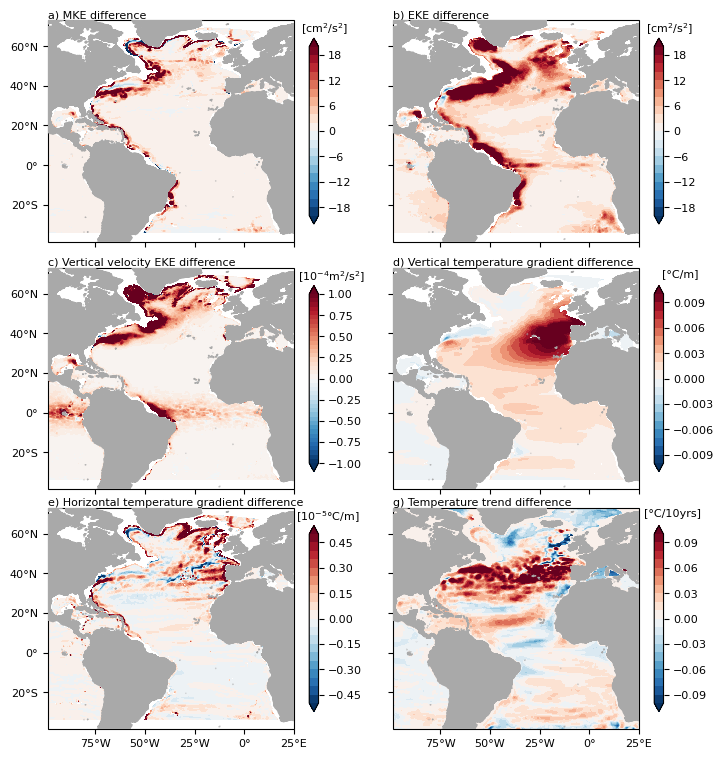

In [80]:
fig = plt.figure(figsize=(7.5,7.5))

ax1 = fig.add_axes([0.06,0.68,0.41,0.31], projection=ccrs.PlateCarree())
ax2 = fig.add_axes([0.52,0.68,0.41,0.31], projection=ccrs.PlateCarree())

ax3 = fig.add_axes([0.06,0.35,0.41,0.31], projection=ccrs.PlateCarree())
ax4 = fig.add_axes([0.52,0.35,0.41,0.31], projection=ccrs.PlateCarree())

ax5 = fig.add_axes([0.06,0.03,0.41,0.31], projection=ccrs.PlateCarree())
ax6 = fig.add_axes([0.52,0.03,0.41,0.31], projection=ccrs.PlateCarree())



######   MKE difference
##
ctf = ax1.contourf(lon, lat, dMKE_23*100**2, cmap='RdBu_r', levels=np.arange(-20,22,2), extend='both')
ax1.set_extent([-99,20,-22,59])
plot_cartopy(ax1, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False)
ax1.set_title('a) MKE difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax1],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[cm$^2$/s$^2$]', y=1.15, labelpad=-20, fontsize=8, rotation=0)


######   EKE difference
##
ctf = ax2.contourf(lon, lat, dEKE_23*100**2, cmap='RdBu_r', levels=np.arange(-20,22,2), extend='both')
ax2.set_extent([-99,20,-22,59])
plot_cartopy(ax2, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False, xlabels=False)
ax2.set_title('b) EKE difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax2],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[cm$^2$/s$^2$]', y=1.15, labelpad=-20, fontsize=8, rotation=0)

## vertical eke
##
ctf = ax3.contourf(lon, lat, 1e4*dEKEw*100**2, levels=np.arange(-1,1.05,0.05), cmap="RdBu_r", extend='both')
ax3.set_extent([-99,20,-22,59])
plot_cartopy(ax3, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), xlabels=False)
ax3.set_title('c) Vertical velocity EKE difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax3],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[10$^{-4}$m$^2$/s$^2$]', y=1.15, labelpad=-22, fontsize=8, rotation=0)

## vertical temperature gradient
##
ctf = ax4.contourf(lon, lat, dgrad_Tz, cmap = 'RdBu_r', levels=np.arange(-0.01,0.011,0.001),
             extend='both')
ax4.set_extent([-99,20,-22,59])
plot_cartopy(ax4, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False, xlabels=False)
ax4.set_title('d) Vertical temperature gradient difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax4],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[°C/m]', y=1.15, labelpad=-25, fontsize=8, rotation=0)


## horizontal temperature gradient
##
ctf =  ax5.contourf(lon, lat, (dgrad_T)*1e5, cmap = 'RdBu_r', levels=np.arange(-0.5,0.55,0.05),
             extend='both')
ax5.set_extent([-99,20,-22,59])
plot_cartopy(ax5, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20))
ax5.set_title('e) Horizontal temperature gradient difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax5],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[10$^{-5}$°C/m]', y=1.15, labelpad=-25, fontsize=8, rotation=0)


## temperature trend
##
ctf = ax6.contourf(lonO, latO, m_B6 - m_O6,
             cmap='RdBu_r', levels=np.arange(-0.1,0.11,0.01), extend='both')
ax6.set_extent([-99,20,-22,59])
plot_cartopy(ax6, xticks=np.arange(-75,26,25), yticks=np.arange(-20,61,20), ylabels=False)
ax6.set_title('g) Temperature trend difference', loc='left', fontsize=8, pad=2)

cb = plt.colorbar(ctf, ax=[ax6],orientation='vertical', shrink=0.8, pad=0.05)
cb.set_label(r'[°C/10yrs]', y=1.15, labelpad=-25, fontsize=8, rotation=0)


plt.savefig('Supplement_Resolution_maps.png', dpi=300)

## Save data for publication 
* full output for main plot (annual mean MHW characteristics) already stored 

In [46]:
MKE_xr = dsC.MKE.drop('depthw')
MKE_xr.attrs['long_name'] = 'Mean kinetic energy resampled on hosting grid (VIKING20X)'
MKE_xr.attrs['units'] = 'm^2 s^-2'

EKE_xr = dsC.EKE.drop('depthw')
EKE_xr.attrs['long_name'] = 'Eddy kinetic energy resampled on hosting grid (VIKING20X)'
EKE_xr.attrs['units'] = 'm^2 s^-2'

EKEw_xr = dsC.EKEw.drop('depthw')
EKEw_xr.attrs['long_name'] = 'Eddy kinetic energy of vertical velocity resampled on hosting grid (VIKING20X)'
EKEw_xr.attrs['units'] = 'm^2 s^-2'

grad_Tz_xr = dsC.grad_Tz.drop('depthw')
grad_Tz_xr.attrs['long_name'] = 'Vertical temperature gradient resampled on hosting grid (VIKING20X)'
grad_Tz_xr.attrs['units'] = 'degC m^-1'

grad_T_xr = dsC.grad_T.drop('depthw')
grad_T_xr.attrs['long_name'] = 'Horizontal temperature gradient resampled on hosting grid (VIKING20X)'
grad_T_xr.attrs['units'] = 'degC m^-1'


/tmp/ipykernel_1885317/975942531.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  MKE_xr = dsC.MKE.drop('depthw')
/tmp/ipykernel_1885317/975942531.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  EKE_xr = dsC.EKE.drop('depthw')
/tmp/ipykernel_1885317/975942531.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  EKEw_xr = dsC.EKEw.drop('depthw')
/tmp/ipykernel_1885317/975942531.py:13: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grad_Tz_xr = dsC.grad_Tz.drop('depthw')
/tmp/ipykernel_1885317/975942531.py:17: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grad_T_xr = dsC.grad_T.drop('depthw')


In [47]:
MKE_O6_xr = MKE_O6.isel(x=range(6,486), y=range(354,853)).drop('deptht')
MKE_O6_xr.attrs['long_name'] = 'Mean kinetic energy (ORCA025)'
MKE_O6_xr.attrs['units'] = 'm^2 s^-2'

EKE_O6_xr = EKE_O6.isel(x=range(6,486), y=range(354,853)).drop('deptht')
EKE_O6_xr.attrs['long_name'] = 'Eddy kinetic energy (ORCA025)'
EKE_O6_xr.attrs['units'] = 'm^2 s^-2'


EKEw_O6_xr = EKEw_O6.isel(x=range(6,486), y=range(354,853)).drop('depthw')
EKEw_O6_xr.attrs['long_name'] = 'Eddy kinetic energy of vertical velocity (ORCA025)'
EKEw_O6_xr.attrs['units'] = 'm^2 s^-2'

grad_Tz_O6_xr = gradT_z23_O6.isel(x=range(6,486), y=range(354,853))
grad_Tz_O6_xr.attrs['long_name'] = 'Vertical temperature gradient (ORCA025)'
grad_Tz_O6_xr.attrs['units'] = 'degC m^-1'

grad_T_O6_xr = gradT_23_O6.isel(x=range(6,486), y=range(354,853)) 
grad_T_O6_xr.attrs['long_name'] = 'Horizontal temperature gradient (ORCA025)'
grad_T_O6_xr.attrs['units'] = 'degC m^-1'

/tmp/ipykernel_1885317/2602902446.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  MKE_O6_xr = MKE_O6.isel(x=range(6,486), y=range(354,853)).drop('deptht')
/tmp/ipykernel_1885317/2602902446.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  EKE_O6_xr = EKE_O6.isel(x=range(6,486), y=range(354,853)).drop('deptht')
/tmp/ipykernel_1885317/2602902446.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  EKEw_O6_xr = EKEw_O6.isel(x=range(6,486), y=range(354,853)).drop('depthw')


In [72]:
m_O6_xr = m_O6.rename({'x':'x1', 'y':'y1'}).drop('degree')
m_O6_xr.attrs['long_name'] = 'Linear regression slope of the temperature (ORCA025)'
m_O6_xr.attrs['units'] = 'degC yr^-1'

m_B6_xr = m_B6.rename({'x':'x1', 'y':'y1'}).drop('degree')
m_B6_xr.attrs['long_name'] = 'Linear regression slope of the temperature resampled on hosting grid (VIKING20X)'
m_B6_xr.attrs['units'] = 'degC yr^-1'

lonO_xr = lonO.rename({'x':'x1', 'y':'y1'})
latO_xr = latO.rename({'x':'x1', 'y':'y1'})

/tmp/ipykernel_1885317/1560832862.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  m_O6_xr = m_O6.rename({'x':'x1', 'y':'y1'}).drop('degree')
/tmp/ipykernel_1885317/1560832862.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  m_B6_xr = m_B6.rename({'x':'x1', 'y':'y1'}).drop('degree')


In [73]:
ds_out = xr.Dataset(data_vars = {'MKE_V20':MKE_xr, 'EKE_V20':EKE_xr, 'EKEw_V20':EKEw_xr, 'grad_Tz_V20':grad_Tz_xr , 'grad_T_V20': grad_T_xr,
                                 'MKE_025':MKE_O6_xr, 'EKE_025':MKE_O6_xr, 'EKEw_025':EKEw_O6_xr, 'grad_Tz_025':grad_Tz_O6_xr , 'grad_T_025': grad_T_O6_xr,
                                 'slope_V20':m_B6_xr, 'slope_025':m_O6_xr, 'lon':lonO_xr, 'lat':latO_xr})

In [75]:
## set global attributes
ds_out.attrs['title'] = 'Comparison between VIKING20X and ORCA025 in 1000 m depth'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 7_MapsResolution.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X, ORCA025'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-01-16'
ds_out.attrs['date_modified'] = '2025-01-16'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [76]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure07.nc')